<a href="https://colab.research.google.com/github/chris-william0829/advGAN-MNIST/blob/main/advGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os.path
from torchvision.utils import save_image

In [2]:
# 数据加载
train_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

batch_size = 64

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=1)

100%|██████████| 9912422/9912422 [00:00<00:00, 103558183.99it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23992017.00it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25493648.22it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3733201.80it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,6,3,stride=1,padding=1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5,stride=1,padding=1),
            nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
            nn.Linear(576,120),
            nn.Linear(120,84),
            nn.Linear(84,10)
        )
    def forward(self,x):
        out = self.conv(x)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

In [4]:
def train(network):

    losses = []
    iteration = 0

    epochs = 10

    for epoch in range(epochs):
        loss_sum = 0
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            pred = network(X)
            loss = loss_fn(pred, y)

            loss_sum += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_loss = loss_sum / len(train_dataloader.dataset)
        losses.append(mean_loss)
        iteration += 1
        print(f"Epoch {epoch+1} loss: {mean_loss:>7f}")

    # 训练完毕保存最后一轮训练的模型
    torch.save(network.state_dict(), "model.pth")

    # 绘制损失函数曲线
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.plot(list(range(iteration)), losses)

cuda:0
Epoch 1 loss: 0.021555
Epoch 2 loss: 0.004917
Epoch 3 loss: 0.003481
Epoch 4 loss: 0.002553
Epoch 5 loss: 0.002012
Epoch 6 loss: 0.001706
Epoch 7 loss: 0.001506
Epoch 8 loss: 0.001359
Epoch 9 loss: 0.001246
Epoch 10 loss: 0.001155


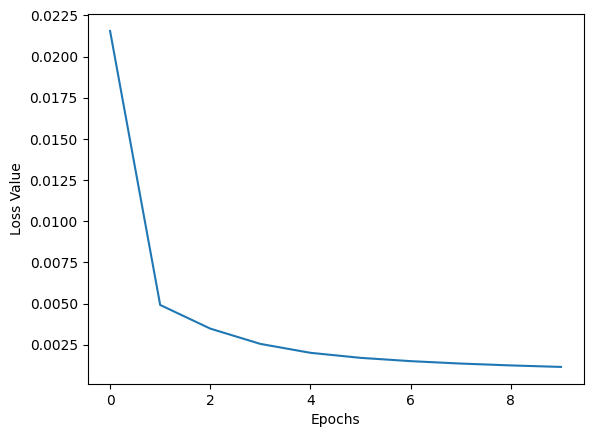

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
network = LeNet()
network.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=network.parameters(), lr=0.001, momentum=0.9)

if os.path.exists('model.pth'):
    network.load_state_dict(torch.load('model.pth'))
else:
    train(network)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # MNIST:1*28*28  cifar:3*32*32
        model = [
            nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            # 8*13*13  cifar:8*15*15
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            # 16*5*5   cifar:16*6*6
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
            # 32*1*1  cifar:32*1*1
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x).squeeze()
        return output


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        encoder_lis = [
            # MNIST:1*28*28  cifar:3*32*32
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # 8*26*26   cifar:8*30*30
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # 16*12*12   cifar:16*14*14
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            # 32*5*5   cifar:32*6*6
        ]

        bottle_neck_lis = [ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),]

        decoder_lis = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            # state size. 16 x 11 x 11   cifar:16*13*13
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            # state size. 8 x 23 x 23    cifar:8*27*27
            nn.ConvTranspose2d(8, 1, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh()
            # state size. 3 x 28 x 28    cifar:3*32*32
        ]

        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x


# Define a resnet block
# modified from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class advGAN:
  def __init__(self,device,target_model):
    self.device = device
    self.target_model = target_model

    self.G = Generator().to(device)
    self.D = Discriminator().to(device)
    # initialize all weights
    self.G.apply(weights_init)
    self.D.apply(weights_init)

    self.optimizer_G = torch.optim.Adam(self.G.parameters(),lr=0.001,betas=(0.5, 0.999))
    self.optimizer_D = torch.optim.Adam(self.D.parameters(),lr=0.001,betas=(0.5, 0.999))
    

  def train_batch(self, x, labels):
    #optimize D
    perturbation = self.G(x)

    adv_images = torch.clamp(perturbation, -0.3, 0.3) + x
    adv_images = torch.clamp(adv_images, 0, 256)
    self.optimizer_D.zero_grad()
    pred_real = self.D(x)

    #判别器对真实样本的预测，ones_like为1
    loss_D_real = nn.functional.mse_loss(pred_real, torch.ones_like(pred_real,device=self.device))
    loss_D_real.backward()

    pred_fake = self.D(adv_images.detach())
    loss_D_fake = nn.functional.mse_loss(pred_fake, torch.zeros_like(pred_fake,device=self.device))
    loss_D_fake.backward()

    loss_D_GAN = loss_D_fake + loss_D_real
    self.optimizer_D.step()

    #optimize G
    self.optimizer_G.zero_grad()

    pred_fake = self.D(adv_images)
    loss_G_fake = nn.functional.mse_loss(pred_fake, torch.ones_like(pred_fake,device=self.device))
    loss_G_fake.backward(retain_graph=True)

    #calculate perturbation norm
    C = 0.1
    loss_perturb = torch.mean(torch.norm(perturbation.view(perturbation.shape[0], -1), 2, dim=1))

    #calculate adv loss
    logits_model = self.target_model(adv_images)
    probs_model = nn.functional.softmax(logits_model, dim=1)
    onehot_labels = torch.eye(10, device=self.device)[labels]

    real = torch.sum(onehot_labels * probs_model, dim=1)
    other, _ = torch.max((1 - onehot_labels) * probs_model - onehot_labels * 10000, dim=1)
    zeros = torch.zeros_like(other)
    loss_adv = torch.max(real - other, zeros)
    loss_adv = torch.sum(loss_adv)
    adv_lambda = 10
    pert_lambda = 1
    loss_G = adv_lambda * loss_adv + pert_lambda * loss_perturb
    loss_G.backward()
    self.optimizer_G.step()

    return loss_D_GAN.item(), loss_G_fake.item(), loss_perturb.item(), loss_adv.item()

  def train(self, train_dataloader, epochs):
    for epoch in range(epochs):
      loss_D_sum = 0
      loss_G_fake_sum = 0
      loss_perturb_sum = 0
      loss_adv_sum = 0
      for i, (images, labels) in enumerate(train_dataloader, start=0):
        images, labels = images.to(self.device), labels.to(self.device)
        loss_D_batch, loss_G_fake_batch, loss_perturb_batch, loss_adv_batch =  self.train_batch(images, labels)
        loss_D_sum += loss_D_batch
        loss_G_fake_sum += loss_G_fake_batch
        loss_perturb_sum += loss_perturb_batch
        loss_adv_sum += loss_adv_batch

      num_batch = len(train_dataloader)
      print("epoch:{}loss_D:{}loss_G:{}loss_P:{}loss_A:{}".format(epoch+1, loss_D_sum/num_batch, loss_G_fake_sum/num_batch, loss_perturb_sum/num_batch, loss_adv_sum/num_batch))
      if (epoch+1) % 20 == 0:
          G_file_name = 'G_epoch_' + str(epoch) + '.pth'
          torch.save(self.G.state_dict(), G_file_name)

In [9]:
network.eval()
advGan = advGAN(device, network)
advGan.train(train_dataloader,40)

epoch:1loss_D:0.15842470453420618loss_G:0.6309073982017634loss_P:9.66667384582796loss_A:1.4108575130862469
epoch:2loss_D:0.01872406440398801loss_G:0.888245046710663loss_P:7.692552643289952loss_A:0.28293630301253375
epoch:3loss_D:0.008916715004564282loss_G:0.9342281540700876loss_P:6.917520877903204loss_A:0.19781644415181837
epoch:4loss_D:0.005295333954486261loss_G:0.9518623609405591loss_P:6.458274796064983loss_A:0.1563301318362832
epoch:5loss_D:0.00564085430409665loss_G:0.959991170780491loss_P:6.686477860916398loss_A:0.12893611458001106
epoch:6loss_D:0.0035271285767343066loss_G:0.969349443404151loss_P:6.1260531177398745loss_A:0.11937336299592244
epoch:7loss_D:0.002353824533729455loss_G:0.9776123622968507loss_P:6.9547421489951455loss_A:0.11954893046287077
epoch:8loss_D:0.0025630013002685883loss_G:0.9797146600573811loss_P:5.613891724076098loss_A:0.09475366829999729
epoch:9loss_D:0.0017419119858284923loss_G:0.9830622725141074loss_P:5.573262354458318loss_A:0.08409796323158594
epoch:10loss_D

In [10]:
adv_examples = []
num_correct = 0
for images, target in test_dataloader:
  images, target = images.to(device), target.to(device)
  perturbation = advGan.G(images)
  perturbation = torch.clamp(perturbation, -0.3, 0.3)
  adv_img = perturbation + images
  adv_img = torch.clamp(adv_img, 0, 1)
  pred_lab = torch.argmax(network(adv_img),1)
  num_correct += torch.sum(pred_lab==target,0)
  if len(adv_examples) < 10:
    adv_examples.append((pred_lab,adv_img))
print('testing dataset:')
print('num_correct: ', num_correct.item())
print('accuracy of adv imgs in testing set: %f\n'%(num_correct.item()/len(test_dataloader)))

testing dataset:
num_correct:  1070
accuracy of adv imgs in testing set: 0.107000



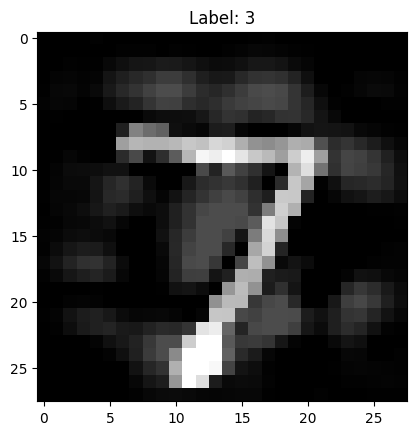

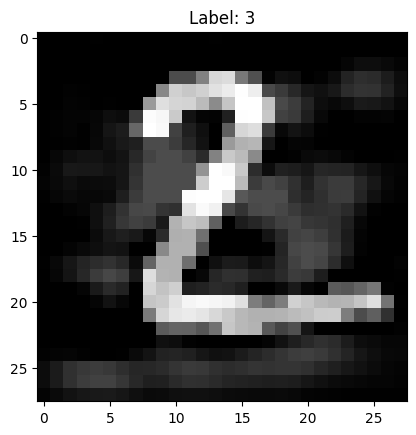

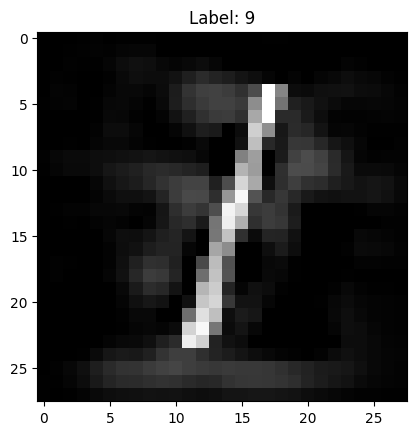

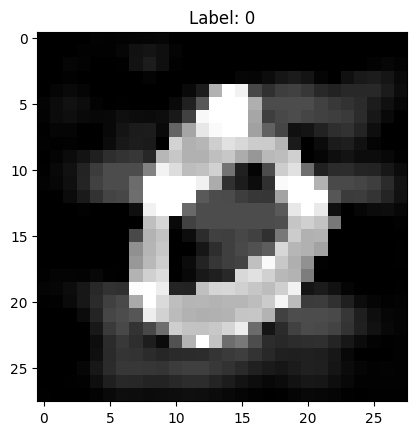

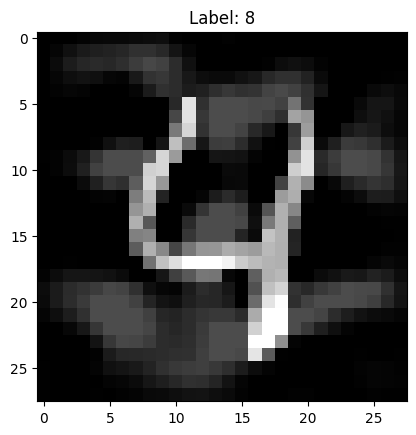

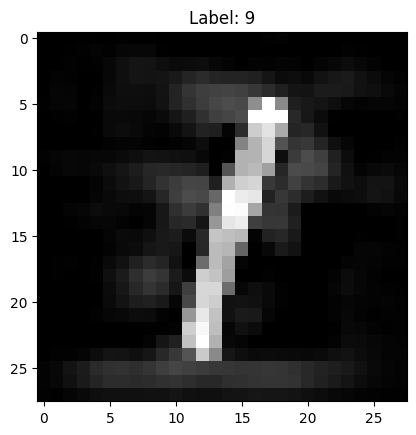

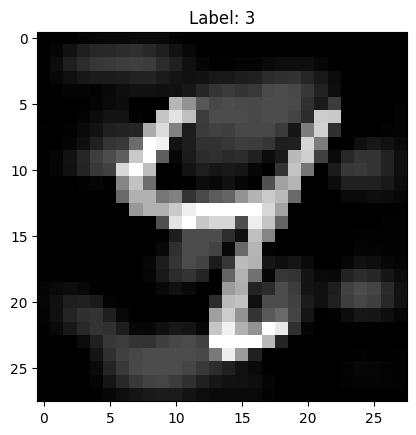

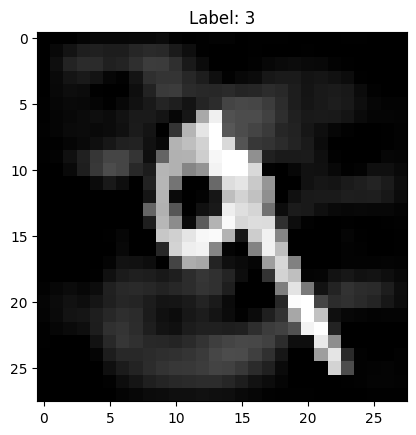

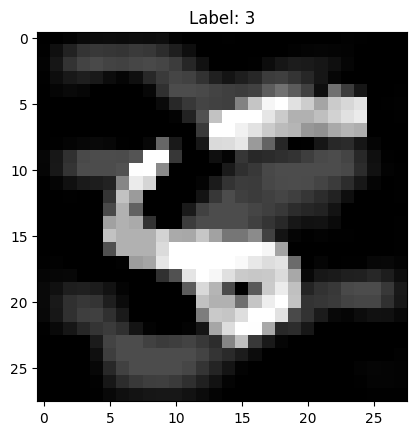

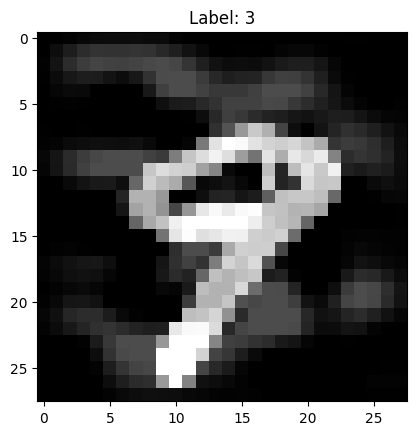

In [26]:
for i in range(len(adv_examples)):
  plt.imshow(adv_examples[i][1].cpu().detach().numpy()[0,0,:,:],cmap="gray")
  plt.title("Label: {}".format(adv_examples[i][0].cpu().detach().numpy()[0]))
  plt.show()